# **Fault Classification and Location in IEEE-13 Node Test Feeder**

In [71]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pywt  # for Continuous Wavelet Transform
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [72]:
class FaultDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory with all the CSV files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = self.get_all_file_paths(root_dir)
        
    def complex_conversion(self, x):
        """Convert a string to a complex number and return real and imaginary parts separately."""
        try:
            complex_num = complex(x)  # Use the built-in complex() function
            return np.round(complex_num.real, 3), np.round(complex_num.imag, 3)
        except ValueError:
            # Handle invalid input
            return 0, 0

    def get_all_file_paths(self, root_dir):
        """Recursively get all CSV file paths in the directory."""
        file_paths = []
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.csv'):
                    file_paths.append(os.path.join(root, file))
        return file_paths
    
    def __len__(self):
        """Returns the number of CSV files."""
        return len(self.data_paths)
    
    def __getitem__(self, idx):
        """Fetch a sample at index idx."""
        data = pd.read_csv(self.data_paths[idx])
        
        # Extracting columns and handling voltages and currents separately (real and imaginary parts)
        time = data['Time'].values
        
        # Apply complex conversion for voltages and currents columns
        voltages_real = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[0])
        voltages_imag = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[1])
        
        currents_real = data[['FaultyBusCurrents_1', 'FaultyBusCurrents_2', 'FaultyBusCurrents_3']].applymap(lambda x: self.complex_conversion(x)[0])
        currents_imag = data[['FaultyBusCurrents_1', 'FaultyBusCurrents_2', 'FaultyBusCurrents_3']].applymap(lambda x: self.complex_conversion(x)[1])

        fault_type = data['FaultType'].values[0]  # Assumes same fault type for all rows 
        fault_location = data['FaultLocation'].values[0]
        
        # Apply transformations (optional)
        if self.transform:
            voltages_real, voltages_imag, currents_real, currents_imag = self.transform(
                voltages_real, voltages_imag, currents_real, currents_imag
            )
        
        # Apply CWT on each phase voltage and current
        cwt_voltage_features = self.apply_cwt(voltages_real, voltages_imag)
        cwt_current_features = self.apply_cwt(currents_real, currents_imag)
        
        # Convert fault type and location to numerical labels
        fault_type_label = self.fault_type_to_label(fault_type)
        fault_location_label = int(fault_location)
        
        return (cwt_voltage_features, cwt_current_features, fault_type_label, fault_location_label)
    
    def apply_cwt(self, real_data, imag_data):
        """Apply Continuous Wavelet Transform (CWT) to each column of real and imaginary parts of data."""
        cwt_data = []
        for phase_real, phase_imag in zip(real_data.T.values, imag_data.T.values):
            # Compute the wavelet transform for each phase (voltages and currents)
            coef_real, _ = pywt.cwt(phase_real, scales=np.arange(1, 128), wavelet='morl')
            coef_imag, _ = pywt.cwt(phase_imag, scales=np.arange(1, 128), wavelet='morl')
            cwt_data.append(np.concatenate([coef_real, coef_imag], axis=0))  # Concatenate real and imaginary coefficients
        return np.array(cwt_data)
    
    def fault_type_to_label(self, fault_type):
        """Convert fault type string to a numerical label."""
        mapping = {'AB': 0, 'AC': 1, 'AG': 2, 'BC': 3, 'BG': 4,
                   'CG': 5, 'ABC': 6, 'ABG': 7, 'ACG': 8, 'BCG': 9,
                   'ABCG': 10, 'NoFault': 11}
        return mapping.get(fault_type, -1)  # Default to -1 if fault_type is not found


C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  voltages_real = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[0])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  voltages_imag = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[1])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  currents_real = data[['FaultyBusCurrents_1', 'FaultyBusCurrents_2', 'FaultyBusCurrents_3']].applymap(lambda x: self.complex_conversion(x)[0])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:46: FutureWarning: DataFrame.applymap has been deprecated.

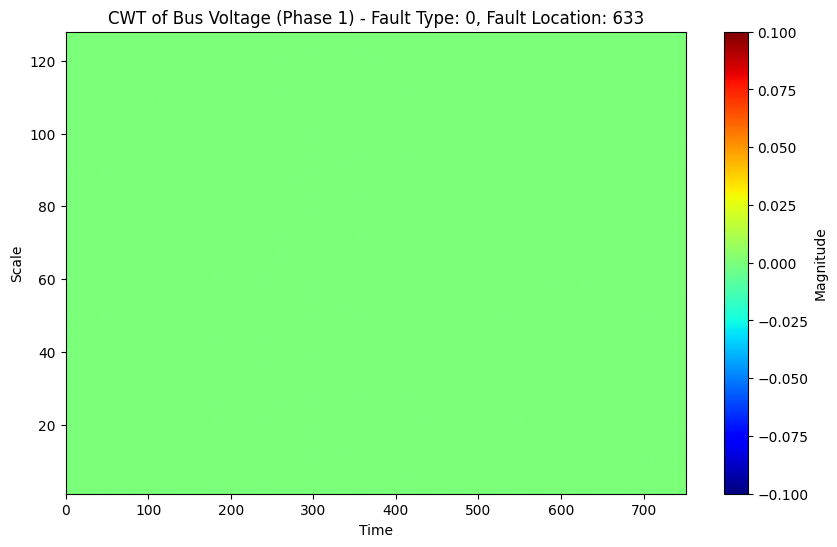

In [75]:
# Path to your CSV files directory (change this to the correct path)
root_dir = 'Fault_Data'

# Initialize the dataset
dataset = FaultDataset(root_dir)

# Test with the first file
sample_idx = 2
cwt_voltage_features, cwt_current_features, fault_type_label, fault_location_label = dataset[sample_idx]

# Select one of the voltage or current CWT features to plot
# For example, select the first bus voltage (phase 1)
cwt_voltage_phase_1 = cwt_voltage_features[0]  # First phase of voltage

# Plotting the CWT of the first bus voltage
plt.figure(figsize=(10, 6))
plt.imshow(cwt_voltage_phase_1, aspect='auto', cmap='jet', extent=[0, cwt_voltage_phase_1.shape[1], 1, 128])
plt.colorbar(label='Magnitude')
plt.title(f'CWT of Bus Voltage (Phase 1) - Fault Type: {fault_type_label}, Fault Location: {fault_location_label}')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

In [49]:

class Augmentation:
    def __init__(self, time_scaling_factor=1.2, noise_level=0.1):
        self.time_scaling_factor = time_scaling_factor
        self.noise_level = noise_level

    def add_noise(self, data):
        """Adds Gaussian noise to the data."""
        noise = np.random.normal(0, self.noise_level, data.shape)
        return data + noise

    def time_scale(self, data):
        """Scale the time series data using interpolation."""
        data = np.asarray(data)

        if data.ndim > 2:
            print(f"Data is too deep: {data.shape}")
            return data  # You can handle higher dimensional data if needed

        if data.ndim == 2:
            # If the data is 2D, apply interpolation to each row/channel
            for i in range(data.shape[0]):
                if len(data[i]) < 2:  # Skip if the row has insufficient data for interpolation
                    continue
                data[i] = np.interp(np.arange(0, len(data[i]), self.time_scaling_factor), 
                                   np.arange(0, len(data[i])), data[i])
        else:
            # For 1D data, apply interpolation directly
            data = np.interp(np.arange(0, len(data), self.time_scaling_factor), 
                             np.arange(0, len(data)), data)

        return data

    def __call__(self, voltages_real, voltages_imag, currents_real, currents_imag):
        """Applies augmentation to the data."""
        # Add noise to the data
        voltages_real = self.add_noise(voltages_real)
        voltages_imag = self.add_noise(voltages_imag)
        currents_real = self.add_noise(currents_real)
        currents_imag = self.add_noise(currents_imag)

        # Apply time scaling
        voltages_real = self.time_scale(voltages_real)
        voltages_imag = self.time_scale(voltages_imag)
        currents_real = self.time_scale(currents_real)
        currents_imag = self.time_scale(currents_imag)

        return voltages_real, voltages_imag, currents_real, currents_imag


# Example usage
if __name__ == "__main__":
    # Example data (random for demonstration)
    voltages_real = np.random.randn(100)
    voltages_imag = np.random.randn(100)
    currents_real = np.random.randn(100)
    currents_imag = np.random.randn(100)

    # Initialize augmentation object
    augmentation = Augmentation()

    # Apply augmentation
    voltages_real, voltages_imag, currents_real, currents_imag = augmentation(voltages_real, voltages_imag, currents_real, currents_imag)

    # Print augmented data
    print("Augmented Data:")
    print("Voltages Real:", voltages_real)
    print("Voltages Imag:", voltages_imag)
    print("Currents Real:", currents_real)
    print("Currents Imag:", currents_imag)


Augmented Data:
Voltages Real: [ 0.01394903  0.53997019  0.00268428 -1.14007758  0.07959403  1.06641841
 -0.38271078  1.42800687  0.38152911 -0.58175191  0.79525858  0.31027126
  1.61283703  0.42211088  0.01298    -0.23829508  1.06207763  0.55359799
 -0.0618038   0.05160331 -1.88253171 -1.35705794  0.64305604  1.93406663
  2.09524204 -0.65064181  0.21726592 -0.01575209  0.29133266  0.29289452
 -0.39423746 -0.24824726 -0.51239699 -0.62295339 -0.27189765  0.17046709
 -0.48703675  0.48551903 -0.56157492  0.18417994 -1.40758273  0.71210642
 -0.42785595  0.24658446  0.15205116 -1.40392145  0.0723241   0.478168
 -1.53086423  0.42864649  0.73751114 -1.06414387 -0.70953336  0.18447126
  0.65111165  2.27926606  2.03683247  1.02262735 -1.44796428 -1.65652095
  1.15388093  0.23357577 -0.22865001 -0.11925    -0.42548421 -0.88119509
  1.04095846 -0.54680636 -0.88883616 -0.29684374 -0.53664823 -0.77994403
 -1.02712585 -0.67073862  0.00441816 -0.91160328 -1.35956474 -0.78807815
 -0.43581042 -0.060622

In [66]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_classes_fault_type, num_classes_fault_location):
        super(CNN_LSTM_Model, self).__init__()
        
        # CNN for extracting features from CWT images
        self.cnn = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=3, padding=1),  # 6 channels (3 voltages + 3 currents)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # LSTM for capturing temporal dependencies
        self.lstm = nn.LSTM(input_size=32*32, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layers for classification
        self.fc_fault_type = nn.Linear(128, num_classes_fault_type)
        self.fc_fault_location = nn.Linear(128, num_classes_fault_location)
    
    def forward(self, voltages_real, voltages_imag, currents_real, currents_imag):
        # Concatenate the real and imaginary parts into a single tensor for input
        voltages = torch.cat((voltages_real, voltages_imag), dim=1)  # Shape: [batch_size, 2, time_steps, height, width]
        currents = torch.cat((currents_real, currents_imag), dim=1)  # Shape: [batch_size, 2, time_steps, height, width]

        # Combine voltages and currents (6 channels in total)
        x = torch.cat((voltages, currents), dim=1)  # Shape: [batch_size, 6, time_steps, height, width]

        # Check the shape before passing to CNN
        print(f"Input shape before CNN: {x.shape}")

        # Ensure the input is of type float32
        x = x.float()

        # Check if the tensor has the correct shape
        batch_size, channels, time_steps, height, width = x.size()
        if len(x.size()) == 3:  # If 3D tensor, add dummy dimensions
            x = x.unsqueeze(2).unsqueeze(3)  # Add height and width dimensions
            
        # Ensure the tensor has the correct number of channels
        if channels != 6:
            raise ValueError(f"Expected 6 channels, but got {channels} channels")

        cwt_features = []
        for t in range(time_steps):
            cnn_out = self.cnn(x[:, t, :, :, :])  # Shape: [batch_size, 16, height, width]
            cnn_out = cnn_out.view(batch_size, -1)  # Flatten for LSTM input
            cwt_features.append(cnn_out)

        cwt_features = torch.stack(cwt_features, dim=1)

        lstm_out, _ = self.lstm(cwt_features)
        lstm_out = lstm_out[:, -1, :]  # Take the last output

        # Fault type classification
        fault_type_out = self.fc_fault_type(lstm_out)
        fault_location_out = self.fc_fault_location(lstm_out)

        return fault_type_out, fault_location_out



In [67]:
# Model, optimizer, and loss functions
model = CNN_LSTM_Model(num_classes_fault_type=12, num_classes_fault_location=12)  
criterion_fault_type = nn.CrossEntropyLoss()
criterion_fault_location = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
def train_model(model, dataloader, num_epochs=50, patience=5):
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for cwt_voltage_features, cwt_current_features, fault_type_label, fault_location_label in dataloader:
            # Assuming cwt_voltage_features and cwt_current_features are complex, we split into real and imaginary components
            voltages_real, voltages_imag = cwt_voltage_features[:, 0], cwt_voltage_features[:, 1]  # Example, adjust indexing based on data shape
            currents_real, currents_imag = cwt_current_features[:, 0], cwt_current_features[:, 1]  # Example, adjust indexing based on data shape
            
            # Augment data if required
            voltages_real, voltages_imag, currents_real, currents_imag = Augmentation()(voltages_real, voltages_imag, currents_real, currents_imag)

            # Convert data to tensors and send to GPU if available
            voltages_real = torch.tensor(voltages_real)
            voltages_imag = torch.tensor(voltages_imag)
            currents_real = torch.tensor(currents_real)
            currents_imag = torch.tensor(currents_imag)
            fault_type_label = torch.tensor(fault_type_label)
            fault_location_label = torch.tensor(fault_location_label)
            
            optimizer.zero_grad()
            fault_type_out, fault_location_out = model(voltages_real, voltages_imag, currents_real, currents_imag)
            
            loss_fault_type = criterion_fault_type(fault_type_out, fault_type_label)
            loss_fault_location = criterion_fault_location(fault_location_out, fault_location_label)
            
            total_loss = loss_fault_type + loss_fault_location
            total_loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}')
        
        # Early stopping
        if total_loss < best_loss:
            best_loss = total_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


In [69]:
# Data loading and training
def main():
    # Specify your data folder path here
    data_folder = 'Fault_Data'  # <<< Provide your data folder path here
    
    # Create the dataset
    dataset = FaultDataset(root_dir=data_folder)
    
    # Create the dataloader
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Training loop
    train_model(model, dataloader, num_epochs=50, patience=5)

if __name__ == "__main__":
    main()


C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  voltages_real = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[0])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  voltages_imag = data[['FaultyBusVoltages_1', 'FaultyBusVoltages_2', 'FaultyBusVoltages_3']].applymap(lambda x: self.complex_conversion(x)[1])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  currents_real = data[['FaultyBusCurrents_1', 'FaultyBusCurrents_2', 'FaultyBusCurrents_3']].applymap(lambda x: self.complex_conversion(x)[0])
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\1484943607.py:46: FutureWarning: DataFrame.applymap has been deprecated.

Data is too deep: (32, 254, 751)
Data is too deep: (32, 254, 751)
Data is too deep: (32, 254, 751)
Data is too deep: (32, 254, 751)
Input shape before CNN: torch.Size([32, 1016, 751])


C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\3692321458.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fault_type_label = torch.tensor(fault_type_label)
C:\Users\Dell\AppData\Local\Temp\ipykernel_18372\3692321458.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fault_location_label = torch.tensor(fault_location_label)


ValueError: not enough values to unpack (expected 5, got 3)